In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import math 
from math import floor
from scipy.stats.mstats import winsorize
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
import stream_data

In [3]:
stream_data.Stream()

[*********************100%***********************]  11 of 11 completed


In [4]:
df = pd.read_csv("data.csv")

In [5]:
# jpy/usd dataset (Yen Giapponese)
df_jpy = pd.read_csv("JPYUSD=X.csv")

In [6]:
df['N225'] = (df['N225']*df_jpy['Close'].mean()) 

In [7]:
#close price in USD
df.tail()

Date         AMD           BTC          ETH         Gold  \
1986  2021-12-22  143.880005  48628.511719  3982.099609  1801.599976   
1987  2021-12-23  146.139999  50784.539062  4108.015625  1811.199951   
1988  2021-12-24  146.139999  50822.195312  4047.982910  1811.199951   
1989  2021-12-25  146.139999  50429.859375  4093.281006  1811.199951   
1990  2021-12-26  146.139999  50809.515625  4067.328125  1811.199951   

             LTC      NVIDIA    Palladium       XLM       XRP        SP500  \
1986  155.467499  294.000000  1887.099976  0.267239  0.954699  4696.560059   
1987  163.449493  296.399994  1954.699951  0.287203  0.993285  4725.790039   
1988  161.421036  296.399994  1954.699951  0.278552  0.912047  4725.790039   
1989  157.785599  296.399994  1954.699951  0.289153  0.924819  4725.790039   
1990  155.992340  296.399994  1954.699951  0.291470  0.921180  4725.790039   

            N225  
1986  261.312421  
1987  263.473006  
1988  263.328643  
1989  263.328643  
1990  263.328643

In [8]:
# no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1991 non-null   object 
 1   AMD        1991 non-null   float64
 2   BTC        1991 non-null   float64
 3   ETH        1991 non-null   float64
 4   Gold       1991 non-null   float64
 5   LTC        1991 non-null   float64
 6   NVIDIA     1991 non-null   float64
 7   Palladium  1991 non-null   float64
 8   XLM        1991 non-null   float64
 9   XRP        1991 non-null   float64
 10  SP500      1991 non-null   float64
 11  N225       1991 non-null   float64
dtypes: float64(11), object(1)
memory usage: 186.8+ KB


In [9]:
df.shape

(1991, 12)

In [10]:
df.describe()

AMD           BTC          ETH         Gold          LTC  \
count  1991.000000   1991.000000  1991.000000  1991.000000  1991.000000   
mean     41.193566  15420.554621   770.210769  1475.338975    96.148345   
std      36.283273  15890.703471  1048.075422   253.410800    62.305584   
min       1.800000   3236.761719    84.308296  1073.900024    23.464331   
25%      12.240000   7143.580078   217.840004  1268.200012    57.876001   
50%      27.780001   8071.259766   320.884003  1336.699951    64.269699   
75%      75.994999  11781.955566   615.567017  1750.200012   131.370743   
max     161.910004  67566.828125  4812.087402  2051.500000   386.450775   

            NVIDIA    Palladium          XLM          XRP        SP500  \
count  1991.000000  1991.000000  1991.000000  1991.000000  1991.000000   
mean     78.712677  1503.047690     0.162491     0.451370  3012.632285   
std      65.884626   682.489271     0.145964     0.369547   707.344319   
min       6.305000   469.899994     0.028182     0.139635  1829.079956   
25%      38.220001   938.375000     0.039946     0.217488  2547.744995   
50%      56.305000  1379.599976     0.093917     0.294664  2846.060059   
75%     115.639999  2134.500000     0.254891     0.528776  3340.969971   
max     333.760010  2985.399902     0.896227     3.377810  4725.790039   

              N225  
count  1991.000000  
mean    205.548025  
std      34.086417  
min     136.794327  
25%     183.488653  
50%     203.024580  
75%     216.700343  
max     280.597255

Descrizione del dataset

In [11]:
counts = []
for col in df.columns:
    na_count = df[df[col].isna()].shape[0]
    counts.append(na_count)

pd.DataFrame(counts, index=df.columns, columns=['NA'])

NA
Date        0
AMD         0
BTC         0
ETH         0
Gold        0
LTC         0
NVIDIA      0
Palladium   0
XLM         0
XRP         0
SP500       0
N225        0

Check per vedere se sono presenti dati mancanti


# Prepocessing : trasformazione del tipo di dati


In [12]:
df.dtypes

Date          object
AMD          float64
BTC          float64
ETH          float64
Gold         float64
LTC          float64
NVIDIA       float64
Palladium    float64
XLM          float64
XRP          float64
SP500        float64
N225         float64
dtype: object

In [13]:
df['Date'] = pd.to_datetime(df['Date'],format = "%Y-%m-%d")

In [14]:
df.dtypes

Date         datetime64[ns]
AMD                 float64
BTC                 float64
ETH                 float64
Gold                float64
LTC                 float64
NVIDIA              float64
Palladium           float64
XLM                 float64
XRP                 float64
SP500               float64
N225                float64
dtype: object

## Grafici preliminari


<AxesSubplot:>

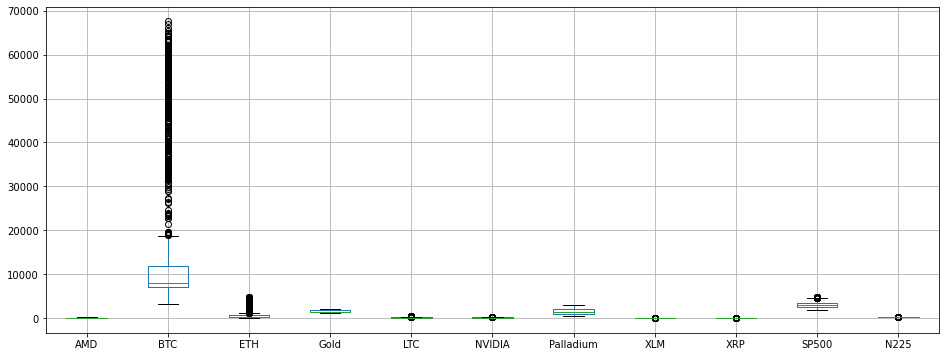

In [15]:
df.boxplot(figsize=(16,6))

In [16]:
df = df[df.Date.dt.year >= 2018]

In [17]:
#copia del dataset
newdf = df.copy()

In [18]:
#uso le date come index
newdf.set_index('Date', inplace=True)

In [19]:
df_cryptocurrencies = newdf[['ETH','BTC','XRP','LTC','XLM']]
df_commodities = newdf[['Palladium','BTC','Gold']]
df_financial_indexes = newdf[['BTC','N225','SP500']]
df_stock_data = newdf[['NVIDIA','BTC','AMD']]

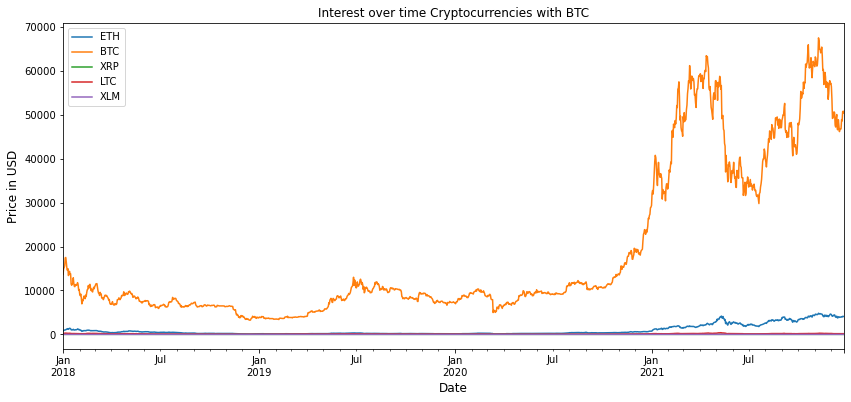

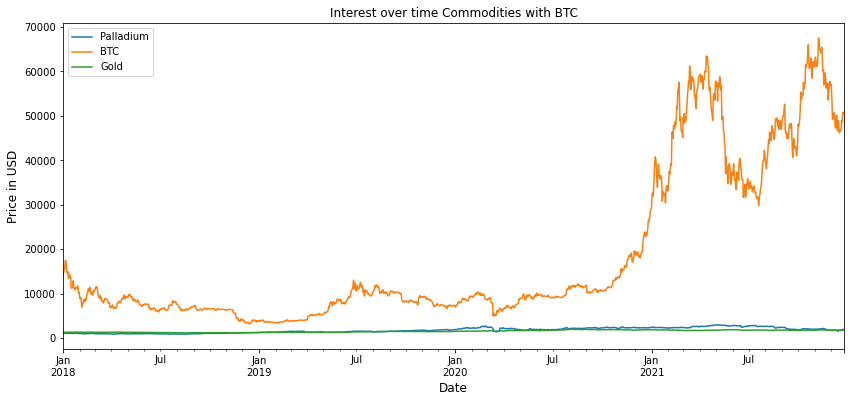

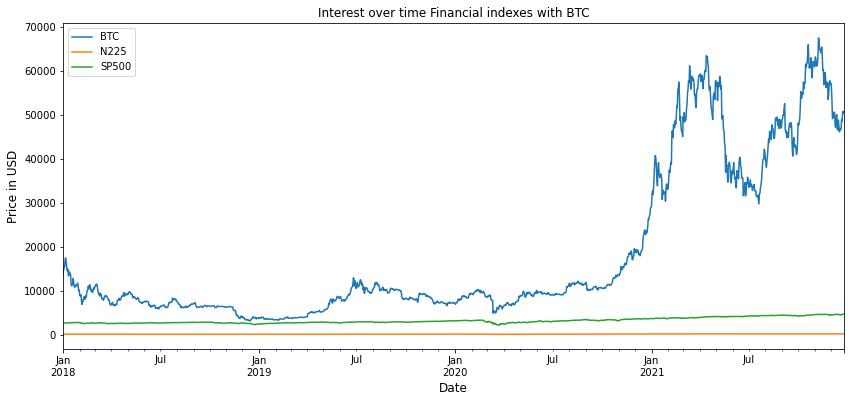

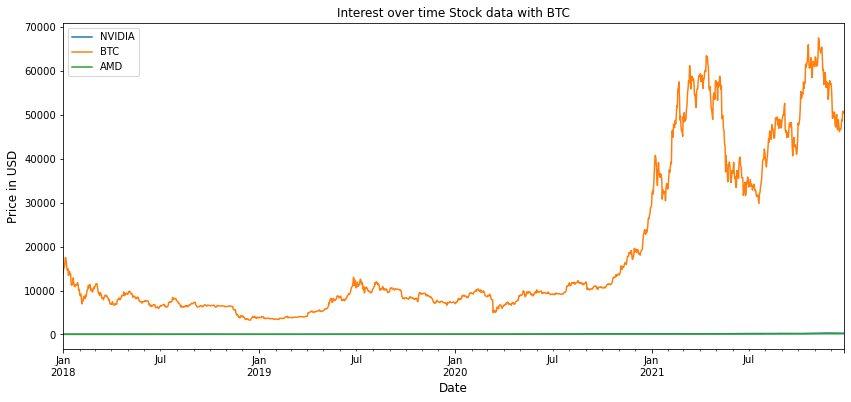

In [20]:
list1 = [df_cryptocurrencies,df_commodities,df_financial_indexes,df_stock_data]
list_name = ['Cryptocurrencies', 'Commodities', 'Financial indexes', 'Stock data']
for i in range(len(list1)):
    
    list1[i].plot(figsize=(14,6))
#df_commodities.plot(figsize=(14,6))
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price in USD', fontsize=12)
    plt.title('Interest over time '+ list_name[i] + ' with BTC');

# Indicatori tecnici

### Simple Moving Average (SMA)

Una semplice media mobile attenua la volatilità e rende più facile visualizzare l'andamento del prezzo di un titolo. Se la media mobile semplice punta verso l'alto, significa che il prezzo del titolo è in aumento. Se punta verso il basso, significa che il prezzo del titolo sta diminuendo.

In [21]:
!pip install plotly

In [22]:
import plotly.express as px

In [23]:
fig = px.line(df, x='Date', y="BTC")
fig.show()

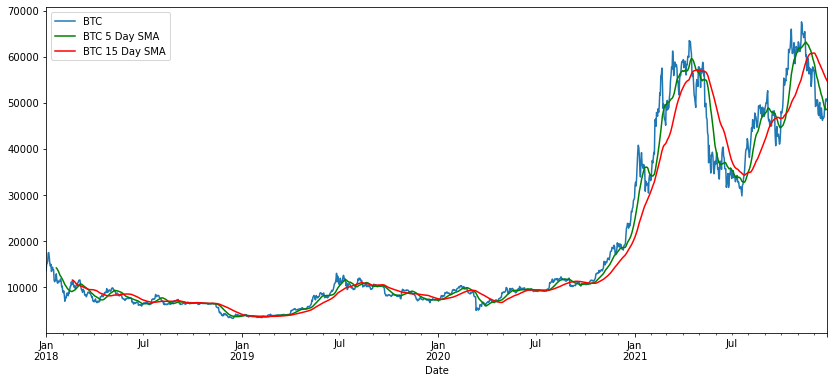

In [24]:
rolling_mean = newdf.BTC.rolling(window= 20).mean()
rolling_mean2 = newdf.BTC.rolling(window= 50).mean()
newdf.BTC.plot(figsize=(14,6),label='BTC')
rolling_mean.plot(label='BTC 5 Day SMA', color='green')
rolling_mean2.plot(label='BTC 15 Day SMA', color='red')
plt.legend(loc='upper left')
plt.show()

Un esempio di utilizzo delle medie mobili è seguire i crossover. Ad esempio, un crossover rialzista si verifica quando la SMA a breve termine supera la SMA a lungo termine. Un crossover ribassista si verifica quando la SMA a breve termine incrocia al di sotto della SMA a lungo termine.

Quando il breve termine supera il lungo termine, riceviamo un segnale di acquisto. Quando il breve termine passa al di sotto del lungo termine, riceviamo un segnale di vendita.

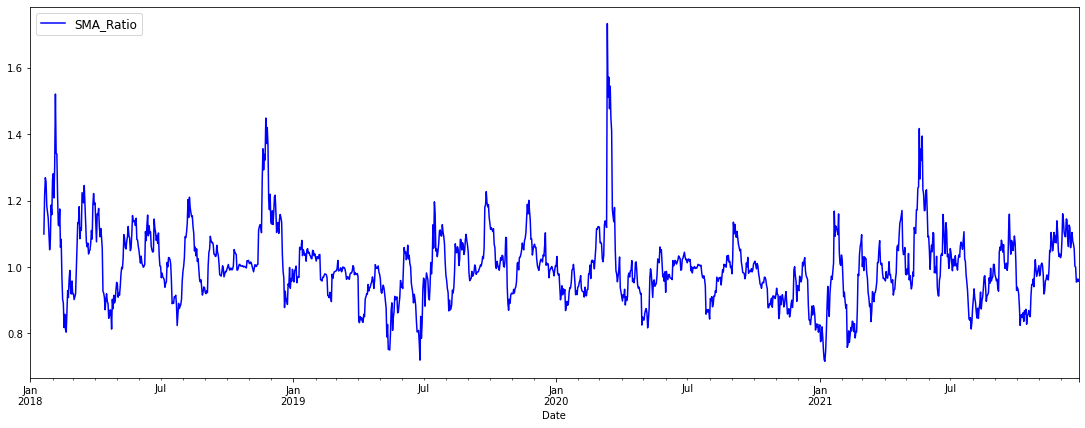

In [25]:
(rolling_mean/newdf.BTC).plot( figsize=(16,6),color = 'blue')
plt.legend(['SMA_Ratio'], ncol=3, loc = 'upper left', fontsize = 12)
plt.subplots_adjust(left=.09, bottom=.09, right=1, top=.95, wspace=.20, hspace=0)

### Exponential Moving Average (EMA)

L'EMA si concentra maggiormente sui dati recenti assegnando più peso ai nuovi dati. L'idea principale alla base dell'EMA è quella di dare la preferenza ai dati recenti rispetto ai dati precedenti. Più vecchi sono i dati, minore è il peso ad essi assegnato. Per questo motivo, l'EMA è più reattiva ai cambiamenti di tendenza rispetto alla SMA, dove a tutti i valori viene assegnato lo stesso peso

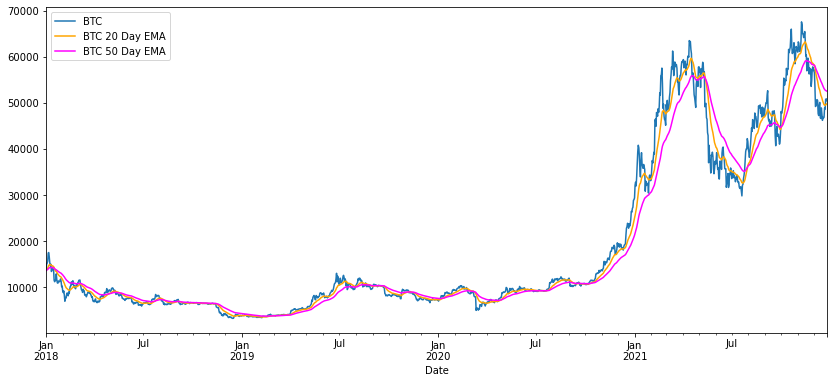

In [26]:
exp1 = newdf.BTC.ewm(span=20, adjust=False).mean()
exp2 = newdf.BTC.ewm(span=50, adjust=False).mean()
newdf.BTC.plot(figsize=(14,6),label='BTC')
exp1.plot(label='BTC 20 Day EMA', color='orange')
exp2.plot(label='BTC 50 Day EMA', color='magenta')
plt.legend(loc='upper left')
plt.show()

### Relative Strength Index (RSI)

In [27]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

btc = newdf.copy()
btc['rsi_14'] = get_rsi(newdf['BTC'], 14)
btc = btc.dropna()
btc.head(3)

AMD           BTC          ETH         Gold         LTC  \
Date                                                                    
2018-01-05  11.88  17429.500000   997.719971  1320.300049  249.270996   
2018-01-06  11.88  17527.000000  1041.680054  1320.300049  296.454010   
2018-01-07  11.88  16477.599609  1153.170044  1320.300049  288.450989   

               NVIDIA    Palladium       XLM      XRP        SP500  \
Date                                                                 
2018-01-05  53.849998  1084.849976  0.662712  3.04871  2743.149902   
2018-01-06  53.849998  1084.849976  0.709945  3.09397  2743.149902   
2018-01-07  53.849998  1084.849976  0.699645  3.37781  2743.149902   

                  N225      rsi_14  
Date                                
2018-01-05  216.961533  100.000000  
2018-01-06  216.961533  100.000000  
2018-01-07  216.961533   93.443257

In [28]:
list1 = list(newdf.columns)


In [29]:
btc = btc.drop(['ETH','XRP','LTC','XLM','Palladium','Gold','N225','SP500','NVIDIA','AMD'], axis = 1)

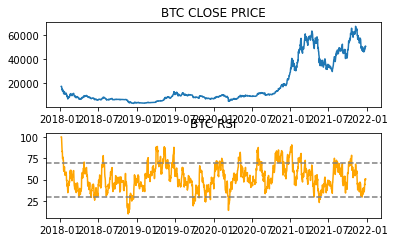

<Figure size 1008x360 with 0 Axes>

In [30]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(btc['BTC'], linewidth = 1.5)
ax1.set_title('BTC CLOSE PRICE')
ax2.plot(btc['rsi_14'], color = 'orange', linewidth = 1.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('BTC RSI')
plt.figure(figsize=(14,5)) 
plt.show()

In [31]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30: #stato di ipervenduto
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70: #stato di ipercomprato
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(btc['BTC'], btc['rsi_14'])

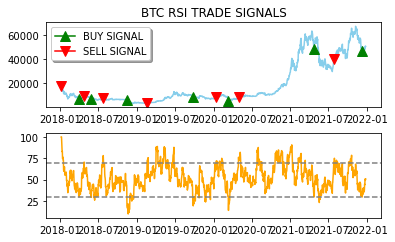

In [32]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(btc['BTC'], linewidth = 1.5, color = 'skyblue')
ax1.plot(btc.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(btc.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('BTC RSI TRADE SIGNALS')
ax2.plot(btc['rsi_14'], color = 'orange', linewidth = 1.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax1.legend(shadow=True, fancybox=True)
plt.show()

## Grafici: prendo in considerazione periodo pandemico

In [33]:
df_2020 = df[df.Date.dt.year >= 2020]

In [34]:
#take exam 2020 year
list2 = list(df_2020.columns[1:])
for i in list2:
    fig = px.line(df_2020,x='Date', y=i)
    fig.show()

Un trend simile è riportato durante il primo anno di pandemia globale da parte di tutti gli indicatori finanziari

<AxesSubplot:xlabel='Date'>

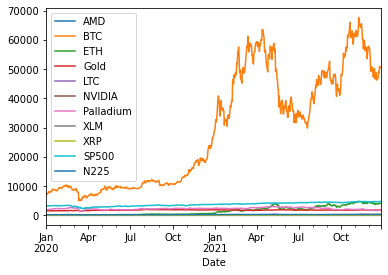

In [35]:
df_2020.plot(x='Date')

Grafico che riporta l'andamento dei vari indicatori presenti nel dataset nell' anno 2020.

## Correlazione di Pearson

In [36]:
#import seaborn as sns
#pearson correlation
#data_corr = newdf.iloc[:, :].corr()
#sns.set(rc={"figure.figsize":(14, 6)})
#sns.heatmap(data_corr, annot=True, cmap='Blues')
#plt.title("pearson correlation map", fontsize=15)



## Returns

I rendimenti nel mercato delle monete non sono altro che una variazione percentuale del prezzo.

In [37]:
#faccio una copia del dataset
df_return = newdf.copy()

In [38]:
#funzione che mi calcola (P1-P0)/P0 il ritorno rispetto al numero di righe specificate nel parametro periods
df_return = df_return.pct_change()

In [39]:
df_return = df_return.drop(df_return.index[0])


In [40]:
df_return.head()

AMD       BTC       ETH      Gold       LTC    NVIDIA  \
Date                                                                     
2018-01-02  0.068093  0.097011  0.144702  0.005665  0.116363  0.030233   
2018-01-03  0.051913  0.014611  0.088503  0.001903 -0.040347  0.065814   
2018-01-04  0.049351  0.026196  0.018907  0.002431 -0.016294  0.005271   
2018-01-05 -0.019802  0.117333  0.017125  0.000682  0.032734  0.008474   
2018-01-06  0.000000  0.005594  0.044061  0.000000  0.189284  0.000000   

            Palladium       XLM       XRP     SP500      N225  
Date                                                           
2018-01-02   0.015134  0.176576  0.037586  0.008303  0.000000  
2018-01-03  -0.003670  0.586900  0.251711  0.006399  0.000000  
2018-01-04   0.010497 -0.192113  0.029388  0.004029  0.032567  
2018-01-05  -0.011436 -0.084715 -0.046274  0.007034  0.008857  
2018-01-06   0.000000  0.071272  0.014846  0.000000  0.000000

## Grafico dei rendimenti

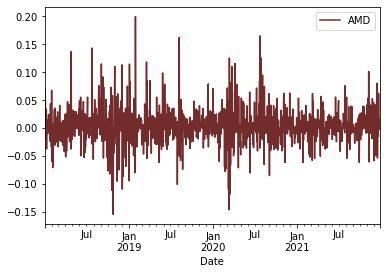

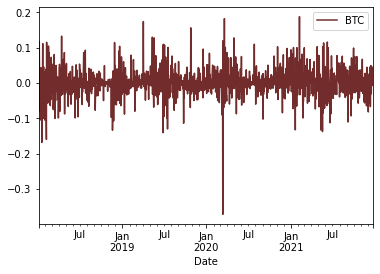

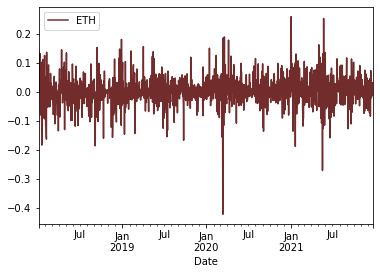

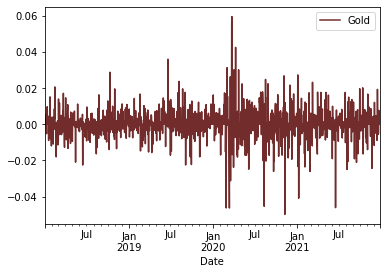

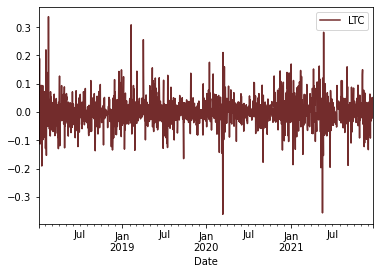

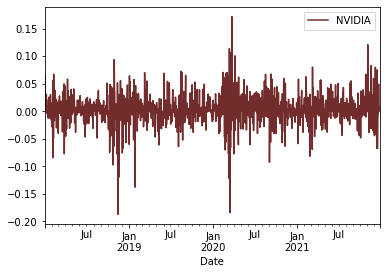

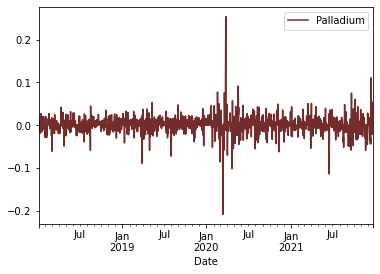

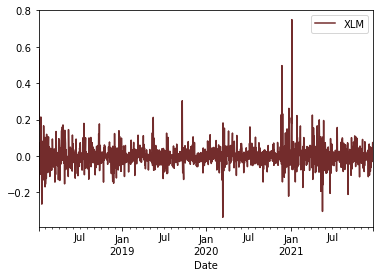

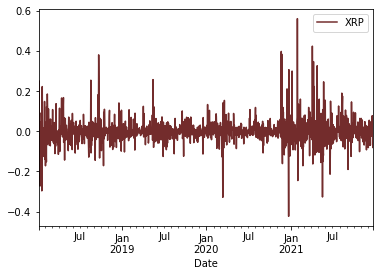

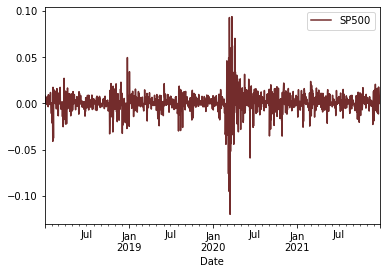

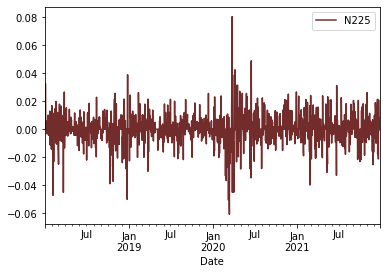

In [41]:
for i in list(df_return.columns):
    
    df_return.plot( y= i , color='#732C2C')

In [42]:
columns = list(df_return.columns)

In [43]:
for i,n in enumerate(columns):
    i = px.line(df_return, x = df_return.index, y = n)
    i.show()

In [44]:
fig = px.line(df_return, x = df_return.index, y = "ETH")
fig.show()

In [45]:
fig = px.line(df_return, x = df_return.index, y = "BTC")
fig.show()

In [46]:

#sns.set(rc={"figure.figsize":(14, 6)})
#sns.heatmap(df_return.iloc[:, :].corr(), annot=True, cmap='Blues')
#plt.title("pearson correlation map", fontsize=15)
#valori bassi nella correlazione tra return

In [47]:
# Function to detect outliers in every feature
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns = ['Feature', 'Number of Outliers'])
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            q1 = dataframe[column].quantile(0.05)
            q3 = dataframe[column].quantile(0.95)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column, 'Number of Outliers':dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers

detect_outliers(df_return)

Feature Number of Outliers
0         AMD                  1
1         BTC                  1
2         ETH                  1
3        Gold                  3
4         LTC                  2
5      NVIDIA                  3
6   Palladium                  4
7         XLM                  3
8         XRP                  6
9       SP500                  8
10       N225                  2

Numero di outliers presenti in ciascuna feature

#### Boxplot dei returns considerando anche gli outliers

<AxesSubplot:>

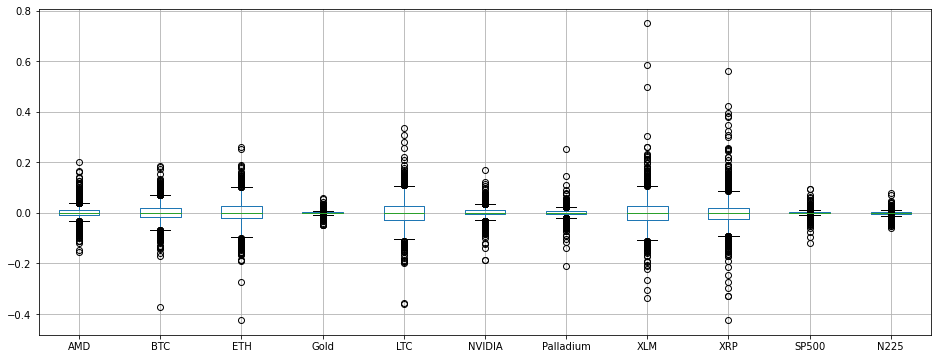

In [48]:
df_return.boxplot(figsize=(16,6))

Eliminazione degli outliers

In [49]:
#Function to treat outliers 
def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe    


df_return2 = df_return.copy()
df_return2 = treat_outliers(df_return2)

In [50]:
detect_outliers(df_return2)

Feature Number of Outliers
0         AMD                  0
1         BTC                  0
2         ETH                  0
3        Gold                  0
4         LTC                  0
5      NVIDIA                  0
6   Palladium                  0
7         XLM                  0
8         XRP                  0
9       SP500                  0
10       N225                  0

#### Boxplot senza considerare gli outliers

<AxesSubplot:>

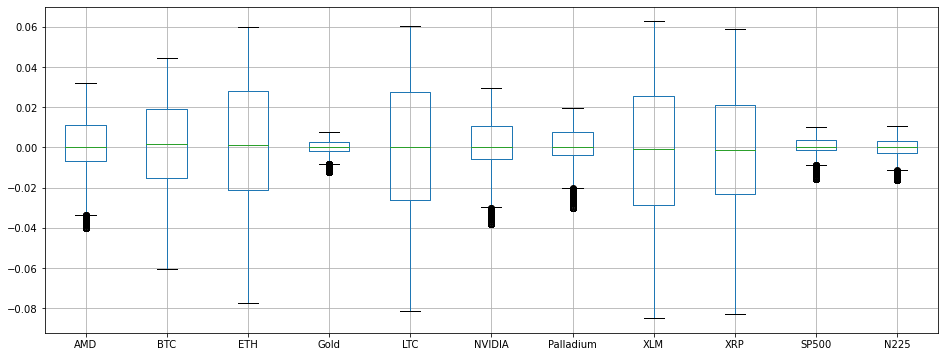

In [51]:
df_return2.boxplot(figsize=(16,6))

## Risk analysis 

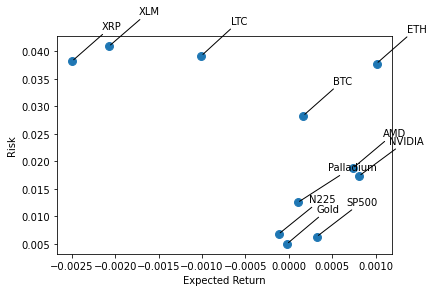

In [52]:
plt.figsize=(18,8)
area=np.pi*20
plt.scatter(df_return2.mean(),df_return2.std(),s=area)
plt.xlabel('Expected Return')
plt.ylabel('Risk')


for label, x,y in zip(df_return2.columns,df_return2.mean(),df_return2.std()):
    plt.annotate(
        label,
        xy=(x,y),xytext=(30,30),
        textcoords='offset points',ha='left',va='bottom',
        arrowprops=dict(arrowstyle='-',connectionstyle='arc,rad=-0.3'))

In [53]:
#df_return2.loc['2020-01-01':]

## Risk Analysis in 2020-21

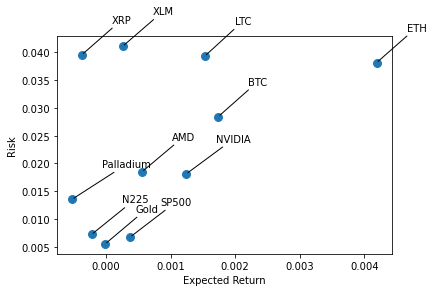

In [54]:
plt.figsize=(18,8)
area=np.pi*20
plt.scatter(df_return2.loc['2020-01-01':].mean(),df_return2.loc['2020-01-01':].std(),s=area)
plt.xlabel('Expected Return')
plt.ylabel('Risk')


for label, x,y in zip(df_return2.loc['2020-01-01':].columns,df_return2.loc['2020-01-01':].mean(),df_return2.loc['2020-01-01':].std()):
    plt.annotate(
        label,
        xy=(x,y),xytext=(30,30),
        textcoords='offset points',ha='left',va='bottom',
        arrowprops=dict(arrowstyle='-',connectionstyle='arc,rad=-2.5'))

## Monte Carlo Simulations

La simulazione Monte Carlo è un modello probabilistico che genera variabili casuali utilizzate in tandem con fattori economici (rendimento atteso, volatilità - nel caso di un portafoglio di fondi) per prevedere i risultati su un ampio spettro. Sebbene non sia il più accurato, il modello viene spesso utilizzato per calcolare il rischio e l'incertezza.

Utilizzeremo ora la simulazione Monte Carlo per generare una serie di rendimenti previsti di Bitcoin che ci aiuteranno a scoprire il VaR.

In [55]:
days= 252
start_price = df_return2.BTC[-1]

In [56]:

def stock_monte_carlo(start_price,days,sigma):
    price=np.zeros(days)
    price[0]=start_price
    shock=np.zeros(days)
    
    
    for x in range(1,days):
        shock[x]=np.random.normal(df_return2.BTC.tail(252).mean(),df_return2.BTC.tail(252).std())
        
        price[x]=price[x-1] + (price[x-1]*(shock[x]))
        
    return price

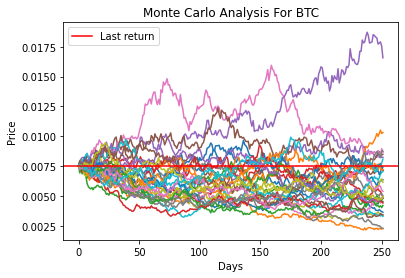

In [57]:

for run in range(30):
    plt.plot(stock_monte_carlo(start_price,days,df_return2.BTC.tail(252).std()))
plt.axhline(y = start_price, color = 'r', linestyle = '-',label="Last return")
plt.legend(loc='upper left')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis For BTC')
plt.ioff()

In [58]:
runs=1000

simulations=np.zeros(runs)

for run in range(runs):
    simulations[run]=stock_monte_carlo(start_price,days,df_return2.BTC.tail(252).std())[days-1]

In [59]:
#sono i 1000 ultimi returni delle simulazioni di Monte Carlo dopo 252 giorni
#simulations

Calculate Monte Carlo average VaR

In [60]:
Var_s=np.percentile(simulations,5)
print('Monte Carlo var: %0.4f' % Var_s)

Monte Carlo var: 0.0024


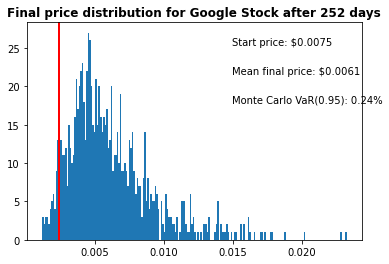

In [61]:


plt.hist(simulations,bins=200)


# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.4f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.4f" % simulations.mean())

# Variance of the price simulation(within 95% confidence interval)
plt.axvline(x= Var_s, linewidth=2, color='r')
t = 100 * Var_s
plt.figtext(0.6, 0.6, "Monte Carlo VaR(0.95): %.2f" % t+'%')





# Plot a line at the 1% quantile result



# Title
plt.title(u"Final price distribution for Google Stock after %s days" % days, weight='bold');

In [62]:
df_return2.head(2)

AMD       BTC       ETH      Gold       LTC    NVIDIA  \
Date                                                                     
2018-01-02  0.032022  0.044337  0.060161  0.005665  0.060293  0.029678   
2018-01-03  0.032022  0.014611  0.060161  0.001903 -0.040347  0.029678   

            Palladium       XLM       XRP     SP500  N225  
Date                                                       
2018-01-02   0.015134  0.062667  0.037586  0.008303   0.0  
2018-01-03  -0.003670  0.062667  0.058942  0.006399   0.0

In [63]:
df_return2.shape[0]

1455

In [64]:
index_Close = df_return2.columns.get_loc("BTC")
index_Close

1

#### Save data into csv file

In [65]:
df_return.to_csv('file2.csv', header=True, index=True)

In [66]:
newdf.to_csv('file3.csv', header=True, index=True)

In [67]:
newdf.head(3)

AMD           BTC         ETH         Gold         LTC  \
Date                                                                   
2018-01-01  10.28  13657.200195  772.640991  1306.300049  229.033005   
2018-01-02  10.98  14982.099609  884.443970  1313.699951  255.684006   
2018-01-03  11.55  15201.000000  962.719971  1316.199951  245.367996   

               NVIDIA  Palladium       XLM      XRP        SP500        N225  
Date                                                                          
2018-01-01  48.375000    1073.75  0.480008  2.39103  2673.610107  208.273843  
2018-01-02  49.837502    1090.00  0.564766  2.48090  2695.810059  208.273843  
2018-01-03  53.117500    1086.00  0.896227  3.10537  2713.060059  208.273843